In [76]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import gc
import cv2
import shap

from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay


# from tensorflow import keras
# from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from matplotlib import pyplot as plt


notebook_dir = os.getcwd()
target_path = os.path.abspath(os.path.join(notebook_dir, '../Python_Code'))
sys.path.append(target_path)
from dataGenerator import DataGenerator, read_mat, DataGeneratorUnified

import util

# Constants
activities = {
  'A': 'Push forward',
  'C': 'Hands up and down',
  'P': 'Reading',
  'S': 'Writing'
}
filter_labels=list(activities.keys())
batchsize = 32
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
labels_array = np.array(labels)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
experiment = {
  'description': 'Compare fine-grained models trained on single monitor and environment vs multiple monitors and environments. Using GradCAM, SHAP and Embeddings',
  'output_dir': '../Output/CompareFineGrainedModelsSingleVsMultipleWithSHAP',
  'shap_background': ['../Data/fine_grained/Classroom/80MHz/3mo/m1/Slots/Train/train_set.csv'],
  'shap_background_count': 100,
  'shap_background_random_seed': 42,
  'work': [
    {
        'model': 'fine_grained_trainedon_Classroom_m1_242.h5', 
        'evaluate_on': ['../Data/fine_grained/Classroom/80MHz/3mo/m1/Slots/Test/test_set.csv'],
    },
    {
        'model': 'fine_grained_trainedon_ClassroomOffice_m1m2m3_242-fixed.h5', 
        'evaluate_on': ['../Data/fine_grained/Classroom/80MHz/3mo/m1/Slots/Test/test_set.csv']
    },
  ]
}


In [168]:
# Utility functions
def create_datagenerators(list_csvs, filter_labels, NoOfClasses=20, NoOfSubcarrier=242, window_size=50, batchsize=48):
  list_test_dir = [os.path.dirname(csv_file_path) for csv_file_path in list_csvs]
  batches = DataGeneratorUnified(list_test_dir, list_csvs, NoOfSubcarrier, NoOfClasses, (window_size, NoOfSubcarrier, 2), batchsize=batchsize, shuffle=False, filter_labels=filter_labels)
  samples = DataGeneratorUnified(list_test_dir, list_csvs, NoOfSubcarrier, NoOfClasses, (window_size, NoOfSubcarrier, 2), batchsize=1, shuffle=False, filter_labels=filter_labels)
  return batches, samples

def read_csv_to_dataframe(list_csvs, filter_labels=None):
  all_dfs = None
  # add a column if name of csv file
  for i, csv_file_path in enumerate(list_csvs):
    df = pd.read_csv(csv_file_path)
    df['source'] = csv_file_path
    if all_dfs is None:
      all_dfs = df
    else:
      all_dfs = pd.concat([all_dfs, df], ignore_index=True)

  if filter_labels is not None:
    df = df[df['label'].isin(filter_labels)]

  return df.reset_index(drop=True)

def plot_confusion_matrix(conf_matrix, labels, filename='confusion_matrix.png'):
  plt.figure(figsize=(32, 32))
  ax = sns.heatmap(conf_matrix, cmap=plt.cm.Greens, annot=True, fmt='d', square=True, xticklabels=labels, yticklabels=labels)
  plt.title("Confusion Matrix")
  ax.set_ylabel('Actual', fontsize=20)
  ax.set_xlabel('Predicted', fontsize=20)
  plt.savefig(filename, bbox_inches='tight', dpi=300)
  plt.close()

def get_embeddings(X, model):
  EMBEDDINGS_LAYER_NAME = "flatten"
  embeddings_layer = model.get_layer(EMBEDDINGS_LAYER_NAME)
  embedding_model = tf.keras.Model(inputs=model.inputs, outputs=embeddings_layer.output)
  embeddings = embedding_model({'input_layer': X}, training=False) 
  return embeddings

def create_background(list_csvs, filter_labels, NoOfClasses=20, NoOfSubcarrier=242, window_size=50, random_state=experiment['shap_background_random_seed']):
  list_test_dir = [os.path.dirname(csv_file_path) for csv_file_path in list_csvs]
  samples = DataGeneratorUnified(list_test_dir, list_csvs, NoOfSubcarrier, NoOfClasses, (window_size, NoOfSubcarrier, 2), batchsize=1, shuffle=False, filter_labels=filter_labels)
  df = pd.read_csv(list_csvs[0])
  df = df[df['label'].isin(filter_labels)].reset_index(drop=True)
  labels = df['label']
  indices = util.amostragem_estratificada_indices(labels, n_amostras=experiment['shap_background_count'], random_state=random_state)

  # Collect the samples at the specified indices
  selected_samples = [samples[i][0] for i in indices]
  return selected_samples


(100, (1, 50, 242, 2))

In [ ]:
def process(experiment):
  start_time = time.time()
  summary = {}

  print(f"Processing experiment: {experiment['description']}")
  print(f"Output directory: {experiment['output_dir']}")
  if not os.path.exists(experiment['output_dir']):
    os.makedirs(experiment['output_dir'])

  background = create_background(experiment['shap_background'], filter_labels)

  for current_work in experiment['work']:
    print(f"Evaluating model: {current_work['model']}")
    
    batches, samples = create_datagenerators(current_work['evaluate_on'], filter_labels=filter_labels, batchsize=batchsize)
    csv_output = read_csv_to_dataframe(current_work['evaluate_on'], filter_labels=filter_labels)
    model = load_model(f"../trained_models/{current_work['model']}")
    gradient_explainer = shap.GradientExplainer(model, background)
    deepexplainer = shap.DeepExplainer(model, background)
    
    gradcam_heatmaps = None
    shap_gradients_heatmaps = None
    shap_deepexapliner_heatmaps = None

    embeddings = None
    csv_output['predicted_label'] = None
    csv_output['predicted_prob'] = None

    # Batches
    for batch_index in tqdm(range(len(batches))):
      X, Y = batches[batch_index]
      gradcam_heatmap, top_pred_index, top_class_channel = util.batch_make_gradcam_heatmap(X, model)
      embedding = get_embeddings(X, model)

      
      shap_values_gradient = gradient_explainer(X)
      shap_values_deepexplainer = deepexplainer(X)

      top_pred_index_np = top_pred_index.numpy()
      idx = top_pred_index_np[:, None, None, None, None]
      shap_values_gradient_selected = np.take_along_axis(shap_values_gradient.values, idx, axis=-1)
      shap_values_gradient_selected = np.squeeze(shap_values_gradient_selected, axis=-1)
      # shap_values_gradient_aggregated1 = np.abs(shap_values_gradient_selected).sum(axis=-1)
      # shap_values_gradient_aggregated2 = np.mean(shap_values_gradient_selected, axis=-1)

      shap_values_deepexplainer_selected = np.take_along_axis(shap_values_deepexplainer.values, idx, axis=-1)
      shap_values_deepexplainer_selected = np.squeeze(shap_values_deepexplainer_selected, axis=-1)
      # shap_values_deepexplainer_aggregated1 = np.abs(shap_values_deepexplainer_selected).sum(axis=-1)
      # shap_values_deepexplainer_aggregated2 = np.mean(shap_values_deepexplainer_selected, axis=-1)

      if gradcam_heatmaps is None:
        gradcam_heatmaps = gradcam_heatmap
      else:
        gradcam_heatmaps = np.concatenate((gradcam_heatmaps, gradcam_heatmap), axis=0)

      if embeddings is None:
        embeddings = embedding
      else:
        embeddings = np.concatenate((embeddings, embedding), axis=0)
      
      if shap_gradients_heatmaps is None:
        shap_gradients_heatmaps = shap_values_gradient_selected
      else:
        shap_gradients_heatmaps = np.concatenate((shap_gradients_heatmaps, shap_values_gradient_selected), axis=0)
      
      if shap_deepexapliner_heatmaps is None:
        shap_deepexapliner_heatmaps = shap_values_deepexplainer_selected
      else:
        shap_deepexapliner_heatmaps = np.concatenate((shap_deepexapliner_heatmaps, shap_values_deepexplainer_selected), axis=0)

      batch_start_index = batch_index * batchsize
      batch_end_index = batch_start_index + len(X)
      csv_output.loc[batch_start_index:batch_end_index - 1, 'predicted_label'] = labels_array[top_pred_index.numpy()]
      csv_output.loc[batch_start_index:batch_end_index - 1, 'predicted_prob'] = top_class_channel.numpy()

    # Remaining samples
    sample_index_start = len(batches) * batchsize

    for sample_index in tqdm(range(sample_index_start, len(samples))):
      X, Y = samples[sample_index]
      gradcam_heatmap, top_pred_index, top_class_channel = util.batch_make_gradcam_heatmap(X, model)
      embedding = get_embeddings(X, model)

      shap_values_gradient = gradient_explainer(X)
      shap_values_deepexplainer = deepexplainer(X)
      top_pred_index_np = top_pred_index.numpy()
      idx = top_pred_index_np[:, None, None, None, None]
      shap_values_gradient_selected = np.take_along_axis(shap_values_gradient.values, idx, axis=-1)
      shap_values_gradient_selected = np.squeeze(shap_values_gradient_selected, axis=-1)
      shap_values_deepexplainer_selected = np.take_along_axis(shap_values_deepexplainer.values, idx, axis=-1)
      shap_values_deepexplainer_selected = np.squeeze(shap_values_deepexplainer_selected, axis=-1)

      gradcam_heatmaps = np.concatenate((gradcam_heatmaps, gradcam_heatmap), axis=0)
      embeddings = np.concatenate((embeddings, embedding), axis=0)
      shap_gradients_heatmaps = np.concatenate((shap_gradients_heatmaps, shap_values_gradient_selected), axis=0)
      shap_deepexapliner_heatmaps = np.concatenate((shap_deepexapliner_heatmaps, shap_values_deepexplainer_selected), axis=0)
      csv_output.at[sample_index, 'predicted_label'] = labels_array[top_pred_index.numpy()].item()
      csv_output.at[sample_index, 'predicted_prob'] = top_class_channel.numpy()[0]

    # Free GPU memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()

    # 
    csv_output['right_prediction'] = csv_output['label'] == csv_output['predicted_label']

    # Summary filenames
    csv_output_filename = f"{experiment['output_dir']}/{current_work['model']}_output.csv"
    gradcam_and_embeddings_filename = f"{experiment['output_dir']}/{current_work['model']}_gradcam_and_embeddings.npz"
    confusion_matrix_filename = f"{experiment['output_dir']}/{current_work['model']}_confusion_matrix.png"

    # Some performance metrics
    accuracy = accuracy_score(csv_output['label'], csv_output['predicted_label'])
    f1 = f1_score(csv_output['label'], csv_output['predicted_label'], average='weighted')
    conf_matrix = confusion_matrix(csv_output['label'], csv_output['predicted_label'], labels=labels)
    summary[f"{current_work['model']}_accuracy"] = accuracy
    summary[f"{current_work['model']}_f1score"] = f1

    # Save outputs
    csv_output.to_csv(csv_output_filename, index=False)
    np.savez_compressed(
      gradcam_and_embeddings_filename, 
      gradcam_heatmaps=gradcam_heatmaps, 
      embeddings=embeddings,
      shap_gradients_heatmaps=shap_gradients_heatmaps,
      shap_deepexapliner_heatmaps=shap_deepexapliner_heatmaps
    )
    plot_confusion_matrix(conf_matrix, labels, filename=confusion_matrix_filename)

  end_time = time.time()
  elapsed_time = end_time - start_time

  summary['elapsed_time_seconds'] = elapsed_time

  # Save summary to a file
  summary_file = os.path.join(experiment['output_dir'], 'summary.txt')
  save_summary = "\n".join([f"{key}: {value}" for key, value in summary.items()])

  with open(summary_file, 'w') as f:
    f.write(f"Experiment: {experiment['description']}\n\n")
    f.write(save_summary)
  print(f"Summary saved to {summary_file}")

  

In [170]:
process(experiment)

Processing experiment: Compare fine-grained models trained on single monitor and environment vs multiple monitors and environments. Using GradCAM, SHAP and Embeddings
Output directory: ../Output/CompareFineGrainedModelsSingleVsMultipleWithSHAP
Evaluating model: fine_grained_trainedon_Classroom_m1_242.h5


/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=(1, 50, 242, 2))', 'Tensor(shape=

Evaluating model: fine_grained_trainedon_ClassroomOffice_m1m2m3_242-fixed.h5


  0%|          | 0/138 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(32, 50, 242, 2))']
  warnings.warn(msg)
/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 50, 242, 2))']
  warnings.warn(msg)
/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(2, 50, 242, 2))']
  warnings.warn(msg)
  1%|          | 1/138 [01:07<2:33:39, 67.30s/it]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/func

Summary saved to ../Output/CompareFineGrainedModelsSingleVsMultipleWithSHAP/summary.txt


In [159]:
data = np.load('../Output/CompareFineGrainedModelsSingleVsMultipleWithSHAP/fine_grained_trainedon_Classroom_m1_242.h5_gradcam_and_embeddings.npz')


In [160]:
shap1 = data['shap_gradients_heatmaps']
shap2 = data['shap_deepexapliner_heatmaps']

In [161]:
shap1_abs = np.abs(shap1).sum(axis=-1)
shap1_mean = np.mean(shap1, axis=-1)
shap2_abs = np.abs(shap2).sum(axis=-1)
shap2_mean = np.mean(shap2, axis=-1)

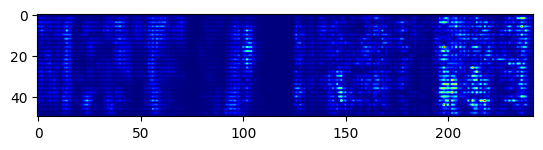

In [165]:
plt.imshow(shap1_abs[2], cmap='jet')


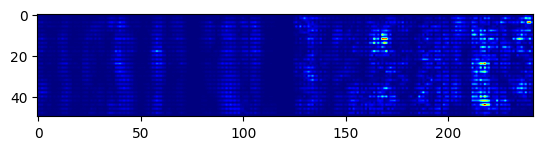

In [149]:
plt.imshow(shap2_abs[0], cmap='jet')

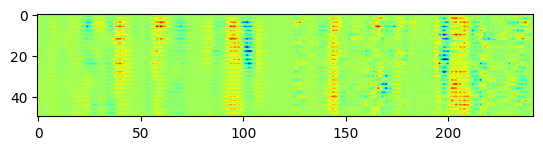

In [150]:
plt.imshow(shap1_mean[0], cmap='jet')

In [7]:
!ls -lah ../Output/CompareFineGrainedModelsSingleVsMultiple

total 266M
drwxrwxr-x 2 diogo diogo 4,0K mai 31 17:28 .
drwxrwxr-x 3 diogo diogo 4,0K mai 27 15:50 ..
-rw-rw-r-- 1 diogo diogo 379K mai 31 17:28 fine_grained_trainedon_Classroom_m1_242.h5_confusion_matrix.png
-rw-rw-r-- 1 diogo diogo 161M mai 31 17:28 fine_grained_trainedon_Classroom_m1_242.h5_gradcam_and_embeddings.npz
-rw-rw-r-- 1 diogo diogo 506K mai 31 17:27 fine_grained_trainedon_Classroom_m1_242.h5_output.csv
-rw-rw-r-- 1 diogo diogo 382K mai 31 22:06 fine_grained_trainedon_ClassroomOffice_m1m2m3_242-fixed.h5_confusion_matrix.png
-rw-rw-r-- 1 diogo diogo  35M mai 31 22:06 fine_grained_trainedon_ClassroomOffice_m1m2m3_242-fixed.h5_gradcam_and_embeddings.npz
-rw-rw-r-- 1 diogo diogo 476K mai 31 22:06 fine_grained_trainedon_ClassroomOffice_m1m2m3_242-fixed.h5_output.csv
-rw-rw-r-- 1 diogo diogo  29M mai 28 17:14 gradcam_heatmaps_A.png
-rw-rw-r-- 1 diogo diogo  22M mai 28 17:15 gradcam_heatmaps_C.png
-rw-rw-r-- 1 diogo diogo 6,8M mai 28 17:15 gradcam_heatmaps_P.png
-rw-rw-r-- 1 diogo